In [1]:
#@title  pip installs
!pip install emcee
!pip install corner
!pip install joypy
!pip install chainconsumer
!pip install autograd

In [2]:
#@title Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import matplotlib
import scipy
import time
from scipy.optimize import minimize
from joypy import joyplot
import autograd
import numpy.linalg as lin
import corner
import emcee
from chainconsumer import ChainConsumer
from multiprocess import Pool, cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

16 CPUs


In [3]:
#@title Get Data
filenames = glob.glob("processed_curves/*.csv")

s = time.time()

lcs_all = {}
for i, filename in enumerate(filenames):
    start = time.time()
    lc = pd.read_csv(filename)
    lcs_all[os.path.basename(filename)] = lc
    
f = time.time()
print("Total loop:", f - s, (f-s)/i)

# Store global constants
passbands = ['g', 'r', 'tess']
pbcols = {'g': 'tab:blue', 'r': 'tab:orange', 'tess': 'tab:purple'}
param_names = ['$t_0$', '$\\beta_1$', '$\\beta_2$', '$c$', '$f_0$']
npar = len(param_names)

Total loop: 18.529311656951904 0.02304640753352227


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
C:\anaconda\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
C:\anaconda\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Days since trigger', ylabel='Flux'>)

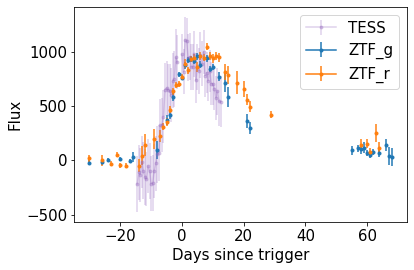

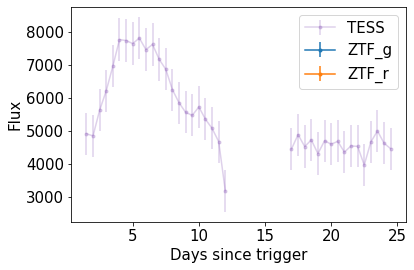

In [4]:
#@title Plot light curve function

font = {'family' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

def plot_light_curve(lc):
    fig, ax = plt.subplots()
    ax.errorbar(lc['relative_time'], lc['tess_flux'], yerr=lc['tess_uncert'], label='TESS', c='tab:purple', marker='.', alpha=0.3)
    ax.errorbar(lc['relative_time'], lc['g_flux'], yerr=lc['g_uncert'], label='ZTF_g', c='tab:blue', marker='.')
    ax.errorbar(lc['relative_time'], lc['r_flux'], yerr=lc['r_uncert'], label='ZTF_r', c='tab:orange', marker='.')
    ax.set_xlabel('Days since trigger')
    ax.set_ylabel('Flux')
    ax.legend()
    fig.tight_layout()

    return fig, ax

plot_light_curve(next(iter(lcs_all.values())))
next(iter(lcs_all.values()))
plot_light_curve(lcs_all['lc_2019bip_ZTF19aallimd_processed.csv'])

In [5]:
#@title Vallely 2021 model
def get_y_pred_vallely(params, t, fit_end_time, z=0):
    t0, b1, b2, c, f0 = params

    # Only predict values until fit_end_time
    dt = (t-t0)/(1+z)
    mask_time = (t < fit_end_time)
    t_pred_hneg = t[mask_time & (dt <= 0)]
    t_pred_hpos = t[mask_time & (dt > 0)]

    dt = (t_pred_hpos-t0)/(1+z)

    y_pred_hneg = f0 + np.zeros(len(t_pred_hneg))
    y_pred_hpos = c * dt**(b1*(1+b2*dt)) + f0

    y_pred = np.concatenate([y_pred_hneg, y_pred_hpos])
    t_pred = np.concatenate([t_pred_hneg, t_pred_hpos])

    return y_pred, t_pred

get_y_pred_vallely([-7.00000000e+00,  6.65605144e-01, -1.74063402e-02, 2.52839505e+02, 1.64430243e-02], np.arange(-30, 50), fit_end_time=20)

(array([1.64430243e-02, 1.64430243e-02, 1.64430243e-02, 1.64430243e-02,
        1.64430243e-02, 1.64430243e-02, 1.64430243e-02, 1.64430243e-02,
        1.64430243e-02, 1.64430243e-02, 1.64430243e-02, 1.64430243e-02,
        1.64430243e-02, 1.64430243e-02, 1.64430243e-02, 1.64430243e-02,
        1.64430243e-02, 1.64430243e-02, 1.64430243e-02, 1.64430243e-02,
        1.64430243e-02, 1.64430243e-02, 1.64430243e-02, 1.64430243e-02,
        2.52855948e+02, 3.94688818e+02, 5.05649979e+02, 5.96609086e+02,
        6.72361946e+02, 7.35704343e+02, 7.88529473e+02, 8.32244737e+02,
        8.67963274e+02, 8.96603736e+02, 9.18947218e+02, 9.35672075e+02,
        9.47376486e+02, 9.54593768e+02, 9.57803229e+02, 9.57438139e+02,
        9.53891782e+02, 9.47522197e+02, 9.38655984e+02, 9.27591442e+02,
        9.14601205e+02, 8.99934502e+02, 8.83819128e+02, 8.66463180e+02,
        8.48056606e+02, 8.28772608e+02]),
 array([-30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18,
        -17, -16, -15

In [6]:
#@title Bayesian likelihood, prior, posterior

def log_likelihood(t_data, y_data, y_data_err, params, fit_end_time, np=np):

    # Only use values until fit_end_time
    mask_time = (t_data < fit_end_time)
    t_data = t_data[mask_time]
    y_data = y_data[mask_time]
    y_data_err = y_data_err[mask_time]

    y_pred, t_pred = get_y_pred_vallely(params, t_data, fit_end_time)

    mse = -0.5 * (y_data - y_pred)**2 / (y_data_err**2)
    sigma_trace = -0.5 * np.log(y_data_err**2)
    log2pi = -0.5 * np.log(2 * np.pi)
    logL = np.sum(mse + sigma_trace + log2pi)
    if np.isnan(logL):
        logL = -np.inf

    return logL


def log_prior(params):
    t0, b1, b2, c, f0 = params

    if not (-30 < t0 < 5):
        return -np.inf
    if not (0 < b1 < 4):
        return -np.inf
    if not (-0.1 < b2 < 0):
        return -np.inf
    # if C < 0 or C > 1:
    #     return -np.inf
    # if f0 < -0.2 or f0 > 0.2:
    #     return -np.inf

    return 0


def log_posterior(t_data, y_data, y_data_err, params, fit_end_time, np=np):
    logL = log_likelihood(t_data, y_data, y_data_err, params, fit_end_time, np)
    logprior = log_prior(params)

    return logL + logprior

In [7]:
#@title Functions for fitting light curves
showProgress = False

class FitLightCurve:
    def __init__(self, lc, pb, fit_end_time):
        self.lc = lc
        self.pb = pb
        self.fit_end_time = fit_end_time
        self.t_data, self.y_data, self.y_data_err = self.get_data()
        self.autodiff_numpy = False
        self.x0 = -5.0, 2.0, -0.001, self.y_data.mean(), 0   # Starting parameters for t0, b1, b2, c, f0

    def get_data(self):
        mask_nans = ~self.lc[f'{self.pb}_flux'].isnull()
        t_data = self.lc['relative_time'][mask_nans].values
        y_data = self.lc[f'{self.pb}_flux'][mask_nans].values
        y_data_err = self.lc[f'{self.pb}_uncert'][mask_nans].values
        return t_data, y_data, y_data_err

    def objective_func_opt(self, params):
        if self.autodiff_numpy:
            np1 = autograd.numpy
        else:
            np1 = np
        
        return -log_likelihood(self.t_data, self.y_data, self.y_data_err, params, self.fit_end_time, np=np1)

    def run_optimizer(self):
        self.autodiff_numpy = False
        opt_params = minimize(self.objective_func_opt, self.x0, method='Nelder-Mead', options={'xatol': 1e-20, 'disp': False},
                                  bounds=((-30, 5), (0,4), (-0.1, 0), (None, None), (None, None))).x

        return opt_params

    def laplace_approximation(self, opt_params, fig_corner=None):
        self.autodiff_numpy = True
        hessian_ = autograd.hessian(self.objective_func_opt)
        cov_matrix = np.linalg.inv(hessian_(opt_params))
        sigmas = np.sqrt(np.diagonal(cov_matrix))
        laplace_samples = np.array([np.random.multivariate_normal(opt_params, cov_matrix) for i in range(20000)])
        fig_corner = corner.corner(laplace_samples, labels=param_names, truths=opt_params, fig_corner=fig_corner,
                                   color='tab:purple', truth_color='black', label="Laplace Approximation");

        return laplace_samples, cov_matrix, sigmas, fig_corner

    def check_enough_data(self, t0, npoints=2):
        # Check that there are at least n points between t0 and maximum
        rise_times = (self.t_data >= t0) & (self.t_data <= self.fit_end_time)
        num_points = np.sum(~np.isnan(self.y_data[rise_times]))
        return num_points >= npoints

    def objective_func_mcmc(self, params):
        return log_posterior(self.t_data, self.y_data, self.y_data_err, params, self.fit_end_time, np=np)

    def get_mcmc_samples(self, opt_params, sigmas, fig_corner=None, nwalkers=100, nsteps=1000, nburn=200, parallelize=False):
        pos = np.nan_to_num(opt_params) + sigmas * np.random.randn(nwalkers, len(opt_params))
        nwalkers, ndim = pos.shape
        if parallelize:
            with Pool() as pool:
                sampler = emcee.EnsembleSampler(nwalkers, ndim, self.objective_func_mcmc, pool=pool)
                sampler.run_mcmc(pos, nsteps=nsteps, progress=showProgress);
        else:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, self.objective_func_mcmc)
            sampler.run_mcmc(pos, nsteps=nsteps, progress=showProgress);
        samples = sampler.get_chain(discard=nburn, flat=True)
        fig_corner = corner.corner(samples, labels=param_names, truths=opt_params, fig=fig_corner,
                                   color='tab:blue', truth_color='black', label="MCMC Samples");
        return samples, fig_corner

    def make_chainconsumer_plot(self, mcmc_samples, laplace_samples, opt_params, param_names, save_name):
        c = ChainConsumer()
        if mcmc_samples is not None:
            c.add_chain(mcmc_samples, parameters=param_names, name='MCMC Samples', color='#1f77b4')
        if laplace_samples is not None:
            c.add_chain(laplace_samples, parameters=param_names, name='Laplace Approximation', color='#9467bd')
        fig = c.plotter.plot(truth=opt_params)
        fig.savefig(save_name)
        return fig

In [8]:
def sigma_clip(df, col,  times=5, const=3):
    for _ in range(0, times):
        mean = df[col].mean()
        threshold = const * df[col].std()
        df = df[np.abs(df[col] - mean) <= threshold]
    return df

def get_approx_sigmas():
    approx_sigmas = dict()
    for pb in passbands:
        sigmas_df = pd.read_csv("old_data/laplace_sigmas.csv", index_col=0)
        pb_cols = [col for col in sigmas_df.columns if pb in col]
        sigmas_pb_df = sigmas_df[pb_cols]
        for pb_col in pb_cols:
            sigmas_pb_df = sigma_clip(sigmas_pb_df, pb_col)
        approx_sigmas[pb] = sigmas_pb_df.mean(axis=0).values.tolist()
    return approx_sigmas

approx_sigmas = get_approx_sigmas()

C:\Users\HALIHU~1\AppData\Local\Temp/ipykernel_12316/384061924.py:11: RuntimeWarning: Mean of empty slice.
  self.x0 = -5.0, 2.0, -0.001, self.y_data.mean(), 0   # Starting parameters for t0, b1, b2, c, f0
C:\anaconda\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\anaconda\lib\site-packages\autograd\tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")
C:\anaconda\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
C:\Users\HALIHU~1\AppData\Local\Temp/ipykernel_12316/384061924.py:11: RuntimeWarning: Mean of empty slice.
  self.x0 = -5.0, 2.0, -0.001, self.y_data.mean(), 0   # Starting parameters for t0, b1, b2, c, f0
C:\anaconda\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  

emcee: Exception while calling your likelihood function:
  params: [-1.45871044e+00  5.14902639e-01 -6.31893568e-02  2.03008389e+04
 -2.31003887e+04]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "C:\anaconda\lib\site-packages\emcee\ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "C:\Users\HALIHU~1\AppData\Local\Temp/ipykernel_12316/384061924.py", line 53, in objective_func_mcmc
    return log_posterior(self.t_data, self.y_data, self.y_data_err, params, self.fit_end_time, np=np)
  File "C:\Users\HALIHU~1\AppData\Local\Temp/ipykernel_12316/1432378674.py", line 41, in log_posterior
    logL = log_likelihood(t_data, y_data, y_data_err, params, fit_end_time, np)
  File "C:\Users\HALIHU~1\AppData\Local\Temp/ipykernel_12316/1432378674.py", line 11, in log_likelihood
    y_pred, t_pred = get_y_pred_vallely(params, t_data, fit_end_time)
  File "C:\Users\HALIHU~1\AppData\Local\Temp/ipykernel_12316/3991543335.py", line 17, in get_y_pred_vallely
    t_pred = np.concatenate([t_pred_hneg, t_pred_hpos])
  File "<__array_function__ internals>", line 180, in concatenate
KeyboardInterrupt


KeyboardInterrupt: 

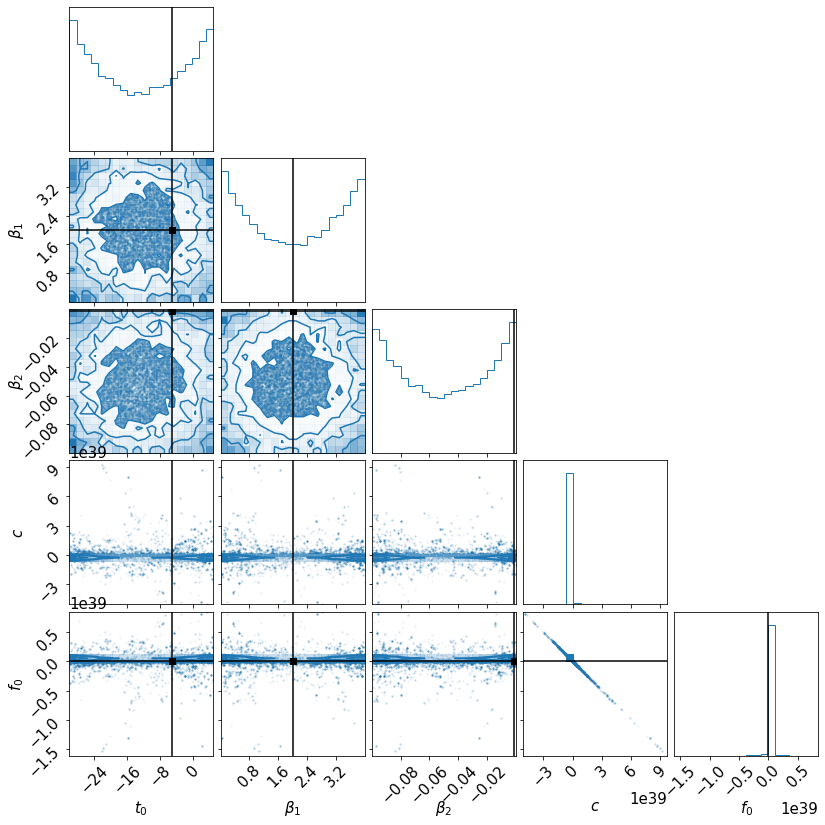

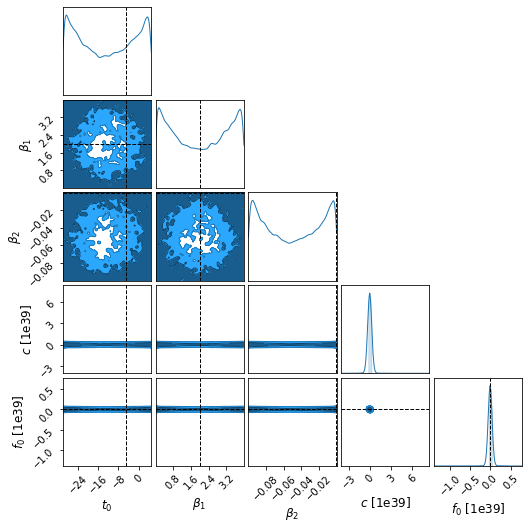

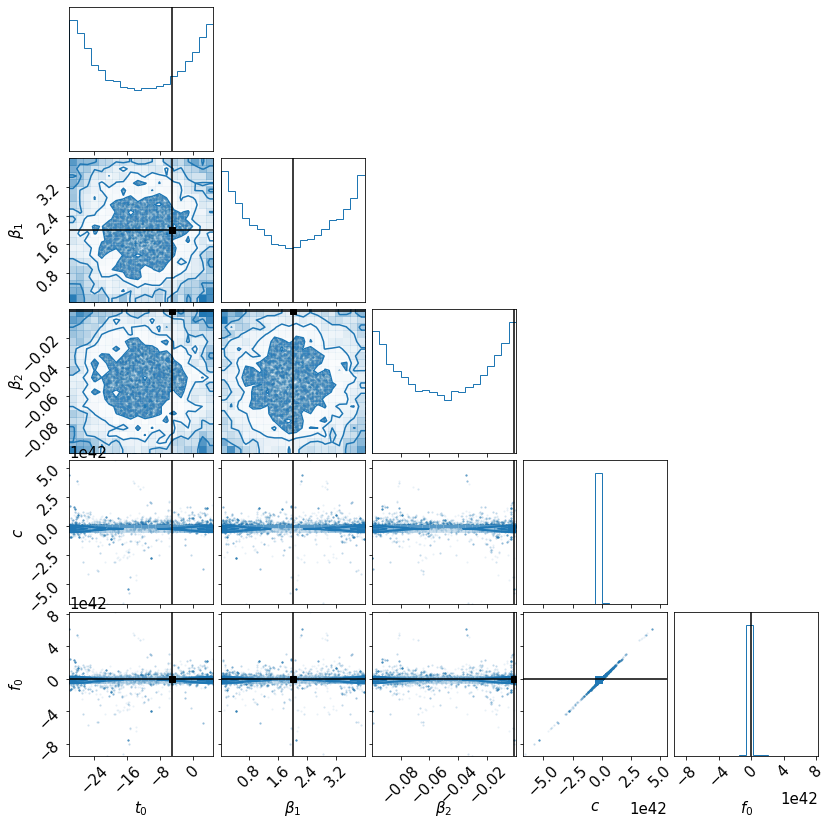

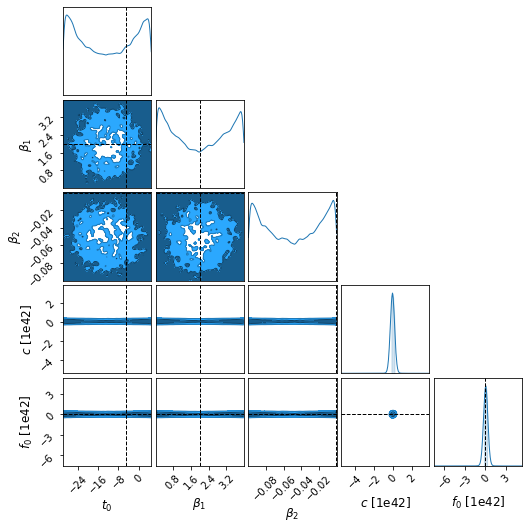

In [9]:
#@title Fit Light curve
def fit_light_curve(lc, run_mcmc=False, parallelize=False, lc_name='', show_fig=False):
    """ Fit one light curve using an optimizer """

    opt_params = {}
    enough_data = {}
    laplace_samples = {}
    laplace_sigmas = {}
    mcmc_samples = {}
    fig_corner = {}

    # Only fit until max flux
    fit_end_time = lc['max_light'][0]

    for pb in passbands:
        fitlc = FitLightCurve(lc, pb, fit_end_time)
        # Run optimizer
        opt_params[pb] = fitlc.run_optimizer()
        # Check that there are at least npoints between t0 and maximum
        enough_data[pb] = fitlc.check_enough_data(opt_params[pb][0], npoints=2)

        # Compute Laplace approximation
        try:
            laplace_samples[pb], cov_matrix, laplace_sigmas[pb], fig_corner[pb] = fitlc.laplace_approximation(opt_params[pb])
        except Exception as e:
            fig_corner[pb] = None
            laplace_samples[pb] = None

        # Run MCMC sampling
        if run_mcmc:
            if not pb in laplace_sigmas or np.isnan(laplace_sigmas[pb]).any():
                sigmas = approx_sigmas[pb]
            else:
                sigmas = laplace_sigmas[pb]
            mcmc_samples[pb], fig_corner[pb] = fitlc.get_mcmc_samples(opt_params[pb], sigmas, fig_corner[pb],
                                                                      nwalkers=100, nsteps=2000, nburn=200, parallelize=parallelize)
            chainconsumer_plot = fitlc.make_chainconsumer_plot(mcmc_samples[pb], laplace_samples[pb], opt_params[pb], param_names,
                                          save_name=f"chainconsumer_plots/{lc_name}_{pb}.pdf")
            if not show_fig: plt.close(chainconsumer_plot)

        if fig_corner[pb] is not None: fig_corner[pb].savefig(f"model_plots/{lc_name}_{pb}_fit.pdf")
        if not show_fig and fig_corner[pb] is not None:
            plt.close(fig_corner[pb])

    return opt_params, fit_end_time, enough_data, laplace_samples, laplace_sigmas, mcmc_samples, fig_corner


start = time.time()
opt_params, fit_end_time, enough_data, laplace_samples, laplace_sigmas, mcmc_samples, fig_corner = fit_light_curve(lcs_all['lc_2019bip_ZTF19aallimd_processed.csv'], run_mcmc=True, lc_name='lc_2019bip_ZTF19aallimd_processed.csv', show_fig=True)
print(f"Time taken: {time.time() - start}s")
print(laplace_samples)
print(mcmc_samples)
#
# for pb in passbands:
#     if pb in fig_corner:
#         plt.close(fig_corner[pb])

In [63]:
#@title Save t0 and plot light curves

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

def load_csv(csv):
    if os.path.exists(csv):
        return pd.read_csv(csv, index_col=0).to_dict('index')
    return {}

def get_t0(samples, enough_data):
    t0_list = []
    for pb in passbands:
        if enough_data[pb] and pb in samples and samples[pb] is not None:
            t0 = np.random.choice(samples[pb][:,0], 100)
            t0_list.append(t0)
    return np.mean(t0_list), np.std(t0_list)

def plot_line(ax, t0_mean, t0_std, color):
    ax.axvline(t0_mean, ls='--', color = 'black')
    ax.axvspan(t0_mean-t0_std/2, t0_mean+t0_std/2, facecolor=f"tab:{color}", alpha=0.5)

laplace_t0_all_lcs = load_csv("laplace_explosion_times.csv")
mcmc_t0_all_lcs = load_csv("mcmc_explosion_times.csv")
save_params = load_csv("optimium_param_values.csv")
# laplace_sigmas_lcs = load_csv("laplace_sigmas.csv")
len_objects = len(lcs_all)
skipped_curves = pd.DataFrame(columns=["curve_name", "error_reason"])
run_mcmc = True
count = 0

def save_lc_params(filename, lc, count):
    if count % 10 == 1:
        pd.DataFrame(laplace_t0_all_lcs).T.to_csv("laplace_explosion_times.csv")
        pd.DataFrame(mcmc_t0_all_lcs).T.to_csv("mcmc_explosion_times.csv")
        pd.DataFrame(save_params).T.to_csv("optimium_param_values.csv")
        pd.DataFrame(skipped_curves).to_csv("skipped_curves.csv")
        # pd.DataFrame(laplace_sigmas_lcs).T.to_csv("laplace_sigmas.csv")

    if filename in save_params or filename in skipped_curves["curve_name"]:
        return

    print(filename)
    name = os.path.splitext(os.path.basename(filename))[0]

    # Fit light curve
    try:
        opt_params, fit_end_time, enough_data, laplace_samples, laplace_sigmas, mcmc_samples, fig_corner = fit_light_curve(lc, run_mcmc=run_mcmc, lc_name=name)
    except Exception as e:
        skipped_curves.append({'curve_name': filename, 'error_reason': str(e)}, ignore_index=True)
        return

    # Get t0
    laplace_t0_mean, laplace_t0_std = get_t0(laplace_samples, enough_data)
    laplace_t0_all_lcs[filename] = {'t0': laplace_t0_mean, 't0_sigma': laplace_t0_std}
    # # save laplace sigmas
    # laplace_sigmas_lcs[filename] = {}
    # for pb in passbands:
    #     if pb in laplace_sigmas:
    #         for j, p_name in enumerate(param_names):
    #              laplace_sigmas_lcs[filename][f'{pb}_{p_name}'] = laplace_sigmas[pb][j]

    if run_mcmc:
        mcmc_t0_mean, mcmc_t0_std = get_t0(mcmc_samples, enough_data)
        mcmc_t0_all_lcs[filename] = {'t0': mcmc_t0_mean, 't0_sigma': mcmc_t0_std}

    # Plot fits
    fig, ax = plot_light_curve(lc)
    for pb in passbands:
        if enough_data[pb]:
            y_pred, t_pred = get_y_pred_vallely(opt_params[pb], lc['relative_time'], fit_end_time)
            ax.plot(t_pred, y_pred, color=pbcols[pb])

    # plot mcmc and laplace t0
    ax.axvline(fit_end_time, ls='-', color = 'black')
    plot_line(ax, laplace_t0_mean, laplace_t0_std, 'green')
    if run_mcmc:
        plot_line(ax, mcmc_t0_mean, mcmc_t0_std, 'red')
    fig.savefig(f"plots/{name}_t0.pdf")
    plt.close(fig)

    # Save parameter values
    save_params[filename] = {f'{pb}_{p_name}': opt_params[pb][i] for i, p_name in enumerate(param_names) for pb in passbands}
    for pb in passbands:
        save_params[filename][f'{pb}_enough_data'] = enough_data.pop(pb)

for i, (filename, lc) in enumerate(lcs_all.items()):
    count += 1
    s1 = time.time()
    save_lc_params(filename, lc, count)
    s2 = time.time()
    print(f"{i+1} of {len_objects}", filename, s2-s1, "seconds")

pd.DataFrame(laplace_t0_all_lcs).T.to_csv("laplace_explosion_times.csv")
pd.DataFrame(mcmc_t0_all_lcs).T.to_csv("mcmc_explosion_times.csv")
pd.DataFrame(save_params).T.to_csv("optimium_param_values.csv")
pd.DataFrame(skipped_curves).to_csv("skipped_curves.csv")
# pd.DataFrame(laplace_sigmas_lcs).T.to_csv("laplace_sigmas.csv")

1 of 805 lc_2018fzi_ZTF18abtkqkb_processed.csv 0.08300614356994629 seconds
2 of 805 lc_2018grv_ZTF18abwerpm_processed.csv 0.0 seconds
3 of 805 lc_2018gxi_ZTF18abzscns_processed.csv 0.0 seconds
4 of 805 lc_2018hgl_ZTF18acbxshd_processed.csv 0.0 seconds
5 of 805 lc_2018hka_ZTF18acbudzh_processed.csv 0.0 seconds
6 of 805 lc_2018hkb_ZTF18acbudzo_processed.csv 0.0 seconds
7 of 805 lc_2018hrs_ZTF18acbufud_processed.csv 0.0 seconds
8 of 805 lc_2018huc_ZTF18acbvcmw_processed.csv 0.0 seconds
9 of 805 lc_2018hxq_ZTF18abyiusv_processed.csv 0.0 seconds
10 of 805 lc_2018hyy_ZTF18acckoil_processed.csv 0.0 seconds
11 of 805 lc_2018ifh_ZTF18accjwuo_processed.csv 0.07799768447875977 seconds
12 of 805 lc_2018ijn_ZTF18acfvhko_processed.csv 0.0 seconds
13 of 805 lc_2018ime_ZTF18achoord_processed.csv 0.0 seconds
14 of 805 lc_2018iti_ZTF18achqdch_processed.csv 0.0 seconds
15 of 805 lc_2018itr_ZTF18acmyxfx_processed.csv 0.0 seconds
16 of 805 lc_2018iuj_ZTF18acmyhbd_processed.csv 0.0 seconds
17 of 805 lc_2018

KeyboardInterrupt: 

In [ ]:
#@title Laplace on every timestep

def approx_laplace_all_timesteps(lc, lc_name, interval_val = 2.0, curve_range = (-30, 30)):
    lc_df = pd.DataFrame([], columns=["t0, t0-sigma"])
    # print(lc_df)
    for end_time in np.arange(curve_range[0], curve_range[1] + interval_val, interval_val):
        print(end_time)
        t0_list = []
        for pb in passbands:
            fitlc = FitLightCurve(lc, pb, end_time)
            if fitlc.check_enough_data(-30, npoints=10):
                # Run optimizer
                lc_opt_params = fitlc.run_optimizer()
                try:
                    samples, _, _, _ = fitlc.laplace_approximation(lc_opt_params)
                    t0 = np.random.choice(samples[:,0], 100)
                    t0_list.append(t0)
                except Exception as e:
                    print(e)
        lc_df.loc[end_time] = {"t0": np.mean(t0_list), "t0-sigma": np.std(t0_list)}
    print(lc_df)
    lc_df.to_csv(lc_name)

for i, (filename, lc) in enumerate(lcs_all.items()):
    print(filename)
    approx_laplace_all_timesteps(lc, filename)
    break


lc_2018fzi_ZTF18abtkqkb_processed.csv
-30.0
-28.0
-26.0
-24.0
-22.0
-20.0
-18.0
-16.0
-14.0
-12.0
-10.0


C:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\anaconda\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\anaconda\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\anaconda\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\anaconda\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-8.0


C:\Users\HALIHU~1\AppData\Local\Temp/ipykernel_12316/384061924.py:39: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diagonal(cov_matrix))
C:\Users\HALIHU~1\AppData\Local\Temp/ipykernel_12316/384061924.py:40: RuntimeWarning: covariance is not positive-semidefinite.
  laplace_samples = np.array([np.random.multivariate_normal(opt_params, cov_matrix) for i in range(20000)])


-6.0


C:\Users\HALIHU~1\AppData\Local\Temp/ipykernel_12316/384061924.py:39: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diagonal(cov_matrix))
C:\Users\HALIHU~1\AppData\Local\Temp/ipykernel_12316/384061924.py:40: RuntimeWarning: covariance is not positive-semidefinite.
  laplace_samples = np.array([np.random.multivariate_normal(opt_params, cov_matrix) for i in range(20000)])


-4.0


C:\Users\HALIHU~1\AppData\Local\Temp/ipykernel_12316/384061924.py:39: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diagonal(cov_matrix))
C:\Users\HALIHU~1\AppData\Local\Temp/ipykernel_12316/384061924.py:40: RuntimeWarning: covariance is not positive-semidefinite.
  laplace_samples = np.array([np.random.multivariate_normal(opt_params, cov_matrix) for i in range(20000)])
C:\Users\HALIHU~1\AppData\Local\Temp/ipykernel_12316/384061924.py:39: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diagonal(cov_matrix))
C:\Users\HALIHU~1\AppData\Local\Temp/ipykernel_12316/384061924.py:40: RuntimeWarning: covariance is not positive-semidefinite.
  laplace_samples = np.array([np.random.multivariate_normal(opt_params, cov_matrix) for i in range(20000)])


-2.0
0.0


C:\Users\HALIHU~1\AppData\Local\Temp/ipykernel_12316/384061924.py:39: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diagonal(cov_matrix))
C:\Users\HALIHU~1\AppData\Local\Temp/ipykernel_12316/384061924.py:40: RuntimeWarning: covariance is not positive-semidefinite.
  laplace_samples = np.array([np.random.multivariate_normal(opt_params, cov_matrix) for i in range(20000)])


2.0
4.0
6.0
8.0


C:\anaconda\lib\site-packages\corner\core.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
C:\Users\HALIHU~1\AppData\Local\Temp/ipykernel_12316/384061924.py:39: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diagonal(cov_matrix))
C:\Users\HALIHU~1\AppData\Local\Temp/ipykernel_12316/384061924.py:40: RuntimeWarning: covariance is not positive-semidefinite.
  laplace_samples = np.array([np.random.multivariate_normal(opt_params, cov_matrix) for i in range(20000)])


10.0


C:\Users\HALIHU~1\AppData\Local\Temp/ipykernel_12316/384061924.py:39: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diagonal(cov_matrix))
C:\Users\HALIHU~1\AppData\Local\Temp/ipykernel_12316/384061924.py:40: RuntimeWarning: covariance is not positive-semidefinite.
  laplace_samples = np.array([np.random.multivariate_normal(opt_params, cov_matrix) for i in range(20000)])


12.0
14.0
16.0
18.0


In [ ]:
#@title Plot best fit parameter distributions

save_params = pd.read_csv('optimium_param_values.csv')

# Remove parameters from passband light curves with not enough data
for pb in passbands:
    for param in param_names:
        save_params[f'{pb}_{param}'] = save_params[f'{pb}_{param}'][save_params[f'{pb}_enough_data']]

# Plot distributions of optimum parameter values

for param in param_names: 
    joyplot(
        data=save_params[[f'{pb}_{param}' for pb in passbands]].rename(columns={f'{pb}_{param}': f'{pb}' for pb in passbands}), 
        # by='cname',
        # figsize=(8, 7),
        kind="kde",
        # hist=True,
        # bins=70,
        # overlap=0,
        alpha=0.8,
        # x_range=(-0.001, 6.1),
        color=list(pbcols.values()),
    )
    # plt.title(f'{param}', fontsize=20)
    plt.xlabel(rf'{param}')
    plt.savefig(f'Distribution_{param}.pdf', bbox_inches='tight')

In [ ]:
save_params[[f'{pb}_{param}' for pb in passbands]].rename(columns={f'{pb}_{param}': f'{pb}' for pb in passbands})

In [ ]:
# save_params[f'{pb}_{param}'] = save_params[f'{pb}_{param}'][save_params[f'{pb}_enough_data']]
# save_params[f'{pb}_enough_data']
# save_params[f'g_{param}'][save_params[f'g_enough_data']]
for pb in passbands:
    for param in param_names:
        save_params[f'{pb}_{param}'] = save_params[f'{pb}_{param}'][save_params[f'{pb}_enough_data']]
save_params

In [ ]:
#@title Unused code



# #@title Fit light curve MCMC
# def fit_light_curve_mcmc(lc):

#     # Only fit until max flux
#     fit_end_time = lc['max_light'][0]

#     opt_params = {}
#     enough_data = {}
#     mcmc_samples = {}
#     fig_corner = {}

#     for pb in passbands:
#         # Get data
#         mask_nans = ~lc[f'{pb}_flux'].isnull()
#         t_data = lc['relative_time'][mask_nans].values
#         y_data = lc[f'{pb}_flux'][mask_nans].values
#         y_data_err = lc[f'{pb}_uncert'][mask_nans].values

#         # Run optimizer
#         def objective_func(params):
#             return log_likelihood(t_data, y_data, y_data_err, params, fit_end_time)

#         x0 = np.array([-5.0, 2.0, -0.001, y_data.mean(), 0.0])   # Starting parameters for t0, b1, b2, c, f0

#         pos = x0 + 0.2 * np.random.randn(100, len(x0))
#         nwalkers, ndim = pos.shape

#         sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_func)
#         sampler.run_mcmc(pos, nsteps=1000, progress=True);
#         samples = sampler.get_chain(discard=100, flat=True)
#         fig_corner[pb] = corner.corner(samples, labels=param_names, truths=x0, color='tab:blue', truth_color='tab:blue');
        
#     return opt_params, fit_end_time, enough_data, samples, fig_corner

# fit_light_curve_mcmc(lcs_all['lc_2018fzi_ZTF18abtkqkb_processed.csv'])




# Original valelly model

# #@title Vallely 2021 model
# def get_y_pred_vallely(params, t, fit_end_time, z=0):
#     t0, b1, b2, c, f0 = params

#     # Only predict values until fit_end_time
#     mask_time = (t < fit_end_time)
#     t_pred = t[mask_time]

#     dt = (t_pred-t0)/(1+z)

#     heaviside = (dt > 0).astype(float) # np.heaviside(dt, 0)
#     y_pred =  heaviside * c * dt**(b1*(1+b2*dt)) + f0
#     # y_pred = np.nan_to_num(y_pred) + f0


#     # for i in range(len(y_pred)):
#     #     print(t_pred[i], dt[i], y_pred[i], (b1*(1+b2*dt))[i])
    
#     # import pdb; pdb.set_trace()

#     return y_pred, t_pred

# get_y_pred_vallely([-7.00000000e+00,  6.65605144e-01, -1.74063402e-02, 2.52839505e+02, 1.64430243e-02], np.arange(-30, 50), fit_end_time=20)





# maxflux_idx = lc[['tess_flux', 'g_flux', 'r_flux']].idxmax()[np.argmax(lc[['tess_flux', 'g_flux', 'r_flux']].max())]
# fit_until = lc['relative_time'][maxflux_idx]


# Fit light curves optimiser
# def fit_light_curve_optimiser(lc):
#     """ Fit one light curve using an optimiser """

#     # Only fit until max flux
#     fit_end_time = lc['max_light'][0]

#     opt_params = {}
#     enough_data = {}

#     for pb in passbands:
#         t_data = lc['relative_time']
#         y_data = lc[f'{pb}_flux']
#         y_data_err = lc[f'{pb}_uncert']

#         def objective_func(params):
#             return -log_likelihood(t_data, y_data, y_data_err, params, fit_end_time)

#         x0 = -5.0, 2.0, -0.001, y_data.mean(), 0.0   # t0, b1, b2, c, f0 = params
#         opt_params[pb] = minimize(objective_func, x0, method='Nelder-Mead', options={'xatol': 1e-12, 'disp': False},
#                                   bounds=((-30, 5), (0,4), (-0.1, 0), (None, None), (None, None))).x

#         # Check that there are at least 2 points between t0 and maximum
#         t0 = opt_params[pb][0]
#         rise_times = (t_data > t0) & (t_data < fit_end_time)
#         num_points = np.sum(~np.isnan(y_data[rise_times]))
#         if num_points <= 2:
#             enough_data[pb] = False
#         else:
#             enough_data[pb] = True
        
#     return opt_params, fit_end_time, enough_data


# # Fit light curves optimiser altogether
# def get_pb_data(lc):
#     t_data = lc['relative_time']
#     y_data = lc[f'{pb}_flux']
#     y_data_err = lc[f'{pb}_uncert']

#     return t_data, y_data, y_data_err

# def fit_light_curve_optimiser(lc):
#     """ Fit one light curve using an optimiser """

#     # Only fit until max flux
#     fit_end_time = lc['max_light'][0]

#     opt_params = {}
#     enough_data = {}

#     def objective_func(params):
#         loglike = 0
#         for pbidx, pb in enumerate(passbands):
#             t_data, y_data, y_data_err = get_pb_data(lc)
#             params_pb = params[np.array([i+pbidx*npar for i in range(npar)])]
#             loglike += log_likelihood(t_data, y_data, y_data_err, params_pb, fit_end_time)

#         return -loglike

#     x0 = [-5.0, 2.0, -0.001, lc['g_flux'].mean(), 0.0, 
#           -5.0, 2.0, -0.001, lc['r_flux'].mean(), 0.0, 
#           -5.0, 2.0, -0.001, lc['tess_flux'].mean(), 0.0]
#     opt_params_list = minimize(objective_func, x0, method='Nelder-Mead', options={'xatol': 1e-12, 'disp': False},
#                                bounds=[(-30, 5), (0,4), (-0.1, 0), (None, None), (None, None)]*3).x

    
#     # Check that there are at least 2 points between t0 and maximum
#     for pbidx, pb in enumerate(passbands):
#         opt_params[pb] = opt_params_list[np.array([i+pbidx*npar for i in range(npar)])]
#         print(np.array([i+pbidx*npar for i in range(npar)]))
        
#         t_data, y_data, y_data_err = get_pb_data(lc)    

#         t0 = opt_params[pb][0]
#         rise_times = (t_data > t0) & (t_data < fit_end_time)
#         num_points = np.sum(~np.isnan(y_data[rise_times]))
#         if num_points <= 2:
#             enough_data[pb] = False
#         else:
#             enough_data[pb] = True
        
#     return opt_params, fit_end_time, enough_data


